In [3]:
# activate autoreload
%load_ext autoreload
%autoreload 2

# check if session is in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print('Google Colab session!')
except:
    IN_COLAB = False
    print('Not a Google Colab session.')

# add src path to the notebook
import os
import sys
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT: str = '/content/drive/MyDrive/papers/2025b_relevance_2.0'
else:
    PROJECT_ROOT: str = os.path.dirname(os.path.dirname(os.path.abspath(os.path.dirname("__file__"))))
if PROJECT_ROOT not in sys.path:
    sys.path.append(os.path.join(PROJECT_ROOT))
print(PROJECT_ROOT)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Not a Google Colab session.
/mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025_GSAI_RES_LLM_Contextual_Predictions


# **California wildfires (Bluesky): Exploratory Spatial Data Analysis**
In this notebook, let's look at the basic properties of the Bluesky data retrieved regarding the 2025 Southern California wildfires.

In [4]:
import torch
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt 
import stopwordsiso as siso
from wordcloud import WordCloud
from nltk.corpus import stopwords
from src.nlp.esda_topic_modelling import TopicModellingOptimiser
from src.nlp.esda_classification import clean_bert, classify_emotions_multilabel, classify_disaster_relatedness
sns.set(style="whitegrid")
sns.set_style('ticks')

from tqdm.auto import tqdm
tqdm.pandas()

# print available GPUs
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"[{i}] {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA GPUs detected.")

DATA_PATH: str = os.path.join(PROJECT_ROOT, 'data')
print(DATA_PATH)

/home/david/miniconda3/envs/contextual-llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[0] NVIDIA RTX A500 Laptop GPU
/mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025_GSAI_RES_LLM_Contextual_Predictions/data


[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **1. Load data**
As always, let's load the data first.

In [3]:
socal_wildfires_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'raw', '2025_socal_wildfires', 'bsky_socal_gdf.parquet'))
print(socal_wildfires_gdf.shape)

# clean the text for processing
socal_wildfires_gdf['cleaned_text'] = socal_wildfires_gdf['text'].progress_apply(lambda x: clean_bert(x))

# extract languages
socal_wildfires_gdf['language'] = socal_wildfires_gdf['langs'].apply(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)
socal_wildfires_gdf['language'] = socal_wildfires_gdf['language'].apply(lambda x: x[:2] if isinstance(x, str) and len(x) > 2 else x)

pd.DataFrame(socal_wildfires_gdf)

(570570, 21)


100%|██████████| 570570/570570 [00:01<00:00, 425902.73it/s]


,cid,uri,author_displayName,author_handle,author_did,createdAt,langs,text,replyCount,repostCount,...,reply_parent_cid,reply_root_cid,image_thumbnails,image_fullsizes,urls,geocoded_dict,language,place,geometry,cleaned_text
0,bafyreiaplar6sf427q46nwwc6fuvipcdtre7xieg4rbn5...,at://did:plc:jodd33f7ckgxejmuvn2jx2mw/app.bsky...,rSutibu (Closed Comms/ Slots:0/8),rsutibu.bsky.social,did:plc:jodd33f7ckgxejmuvn2jx2mw,2024-12-24T00:29:59.418Z,[en],warming... fire!?,1,0,...,bafyreiaxto7bnoivob7f5frvtqld7ae2cio6noepknwet...,bafyreifymdgcqnqfakmjfpgig2lo3zu7q6qmxht4r76z5...,[],[],[],"{'text': 'warming... fire!?', 'toponyms': []}",en,[],MULTIPOINT EMPTY,warming... fire!?
1,bafyreibaovld72qis6wd5xmu2owmw7o2eawpcd4k7e63o...,at://did:plc:3rxcbck5ni5ldif3pvj4ricw/app.bsky...,Nellie Pennington,whoa-nellie.bsky.social,did:plc:3rxcbck5ni5ldif3pvj4ricw,2024-12-24T00:29:47.972Z,[en],That time I had hot chocolate with the snowman...,0,0,...,None,None,[https://cdn.bsky.app/img/feed_thumbnail/plain...,[https://cdn.bsky.app/img/feed_fullsize/plain/...,[bafkreib2zuex4hywb5v3jntsl5b2vdyiambaib5nxswq...,{'text': 'That time I had hot chocolate with t...,en,[],MULTIPOINT EMPTY,That time I had hot chocolate with the snowman...
2,bafyreihrauazmbzzuwxgiam5kvm3iygepclphl57kexrt...,at://did:plc:jedlel7nmsgraeenznupxrf3/app.bsky...,Saint D'Khari,saintdkhari.bsky.social,did:plc:jedlel7nmsgraeenznupxrf3,2024-12-24T00:29:41.279Z,[en],Oh yeah that sounds fire,0,0,...,bafyreihqshfmmile24ungwpbnxs2z2erhvrwrclk27uei...,bafyreih3hppo5jliwmrpzf7kzvc3ob62bzno5nq5noyj4...,[],[],[],"{'text': 'Oh yeah that sounds fire', 'toponyms...",en,[],MULTIPOINT EMPTY,Oh yeah that sounds fire
3,bafyreif2n4ryjuxtawo52giqu4rbxmxkohnq76y5wnhkm...,at://did:plc:skgjhoxiu2upm4e57l2ld3li/app.bsky...,Tilly,hortense1177bce.bsky.social,did:plc:skgjhoxiu2upm4e57l2ld3li,2024-12-24T00:29:27.405Z,[en],I prefer being here to Twitter but I also feel...,2,0,...,None,None,[],[],[],{'text': 'I prefer being here to Twitter but I...,en,[],MULTIPOINT EMPTY,I prefer being here to Twitter but I also feel...
4,bafyreieqwf6wnjkf3vy2aoqyqroa5vqcdnjc3cec6nahc...,at://did:plc:cl37gznnibucnz6dnsqv2vpr/app.bsky...,elliott junkyard,transarchivist.bsky.social,did:plc:cl37gznnibucnz6dnsqv2vpr,2024-12-24T00:29:19.501Z,[en],this whole thread is fire ❤️‍🔥,0,0,...,None,None,[],[],[],"{'text': 'this whole thread is fire ❤️‍🔥', 'to...",en,[],MULTIPOINT EMPTY,this whole thread is fire ❤️‍🔥
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285280,bafyreiblckmpnru7ibeurj5dlwzzudutomwljwkc7artw...,at://did:plc:kuhx6uckdmd465x4bumqxkdk/app.bsky...,Facundo Dell Aqua,facundodellaqua.bsky.social,did:plc:kuhx6uckdmd465x4bumqxkdk,2025-02-14T23:43:52.610Z,[es],"Jajajajajaja, el final es una fatality",0,0,...,bafyreih2rory3qauljgas5ojkjk6b3h6o5gpbz4rfdz6u...,bafyreifemihlizfbq55lkj7fne6xlvpi7pynyfatnty3v...,[],[],[],"{'text': 'Jajajajajaja, el final es una fatali...",es,[],MULTIPOINT EMPTY,"Jajajajajaja, el final es una fatality"
285281,bafyreifwy5xwesv5kczu4mgclv3ptyuzu6vjzxoxac5mh...,at://did:plc:o5bzpjeblsmh45q2hpwswh56/app.bsky...,,devrawiz.bsky.social,did:plc:o5bzpjeblsmh45q2hpwswh56,2025-02-14T23:41:00.396Z,[en],It looks like mobile homes and bulldozers are ...,0,1,...,bafyreidqnlyviql3y22vyxc2e2dyv3xzbvxmzqeox46o4...,bafyreidqnlyviql3y22vyxc2e2dyv3xzbvxmzqeox46o4...,[],[],[],{'text': 'It looks like mobile homes and bulld...,en,[Rafah],MULTIPOINT ((34.24357 31.29722)),It looks like mobile homes and bulldozers are ...
285282,bafyreicckfaghaqchbmtre4w3vknpd6qac2xwmffprzvv...,at://did:plc:hslirr7h6d7livppaxty435b/app.bsky...,Thiard News@F4F,newsen.bsky.social,did:plc:hslirr7h6d7livppaxty435b,2025-02-14T23:58:45Z,None,Forecast for Indoor Air Quality Solution Marke...,0,0,...,None,None,[],[],[https://third-news.com/article/a020f3bc-eb2f-...,{'text': 'Forecast for Indoor Air Quality Solu...,NaN,[USA],MULTIPOINT ((-98.5 39.76)),Forecast for Indoor Air Quality Solution Marke...
285283,bafyreigqs4y4we4rhzh

## **2. Topic modelling**
Next up, let's try to apply topic modelling. We can use the optimisation library from our previous JRC collaboration.

In [9]:
# Instantiate the optimiser
topic_optimiser = TopicModellingOptimiser(
    embedding_model='intfloat/multilingual-e5-small',
    random_state=42,
    verbose=True
)

In [ ]:
# Precompute the embeddings
topic_optimiser.precompute_embeddings(socal_wildfires_gdf['cleaned_text'].tolist(), path=None)
topic_optimiser.precompute_reduced_embeddings(path=None)

We evaluate a few configurations (10, 20, 30 topics x kmeans & hdbscan).

In [ ]:
topic_eval_df: pd.DataFrame = topic_optimiser.evaluate_topic_model(
    texts=socal_wildfires_gdf['cleaned_text'].tolist(),
    evaluation_texts=socal_wildfires_gdf['cleaned_text'].tolist(),          # using same data for simplicity; swap in held-out data if available
    params_nr_topics=[10, 20, 30],
    clustering_algorithms=['hdbscan', 'kmeans'],
    stop_words=(stopwords.words('english') + stopwords.words('spanish') + ['@user', 'http']),
    min_cluster_size=100,
    verbose=True
)

# extract the best configuration
best_config: pd.Series = topic_eval_df.sort_values('train_quality', ascending=False).iloc[0]
best_algo: str = best_config['clustering_algorithm']
best_nr_topics: int = best_config['nr_topics']
print(f"Best config → algorithm: {best_algo}, nr_topics: {best_nr_topics}")

Lastly, we fit the model with the best settings.

In [ ]:
topic_info_df, coherence, diversity, topic_ids = topic_optimiser.fit_transform(
    texts=socal_wildfires_gdf['cleaned_text'].tolist(),
    nr_topics=best_nr_topics,
    stop_words=None,
    clustering_algorithm=best_algo,
    min_cluster_size=100,
    verbose=False
)

#  inspect outputs
print("Assigned topic IDs for each document:", topic_ids)
print("\nTopic information:")
print(topic_info_df)

# add topic IDs to the original dataframe
topic_info_df.set_index('Topic', inplace=True)
socal_wildfires_gdf['topic_id'] = topic_ids
socal_wildfires_gdf["keywords"] = socal_wildfires_gdf["topic"].apply(lambda x: topic_info_df.loc[x, "Representation"])
socal_wildfires_gdf["topic_label"] = socal_wildfires_gdf["keywords"].apply(lambda x: ', '.join(x))

# Save the topic information
topic_info_df.to_csv(os.path.join(DATA_PATH, 'processed', '2025_socal_wildfires', 'esda', 'topic_info.csv'))
socal_wildfires_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', '2025_socal_wildfires', 'esda', 'bsky_socal_gdf_esda.parquet'))

## **3. Emotion classification**
Next, we also want to implement multilabel emotion classification.

In [ ]:
emotions: pd.DataFrame = classify_emotions_multilabel(texts=socal_wildfires_gdf['cleaned_text'].tolist())
socal_wildfires_gdf.loc[:, emotions.columns] = emotions.to_numpy()
socal_wildfires_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', '2025_socal_wildfires', 'esda', 'bsky_socal_gdf_esda.parquet'))

## **4. Disaster-relatedness classification**
Lastly, let's perform disaster-relatedness classification.

In [ ]:
socal_wildfires_gdf['disaster_related'] = classify_disaster_relatedness(texts=socal_wildfires_gdf['cleaned_text'].tolist())
socal_wildfires_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', '2025_socal_wildfires', 'esda', 'bsky_socal_gdf_esda.parquet'))

## **5. Visualisation**
The entire above pipeline can be executed as an individual script on an HPC cluster as follows.

```bash
python -m scripts.esda.nlp_analysis --input-file "./data/raw/2025_socal_wildfires/bsky_socal_gdf.parquet" --output-path "data/processed/2025_socal_wildfires"
```

We can then load the data and do a few visualisations.

In [ ]:
# try reading as geoparquet, else fix geometry
try:
    socal_wildfires_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', '2025_socal_wildfires', 'bsky_socal_gdf_esda.parquet'))
except:
    socal_wildfires_gdf: pd.DataFrame = pd.read_parquet(os.path.join(DATA_PATH, 'processed', '2025_socal_wildfires', 'bsky_socal_gdf_esda.parquet'))
    socal_wildfires_gdf['geometry'] = gpd.GeoSeries.from_wkb(socal_wildfires_gdf['geometry'].values, crs=4326)
    socal_wildfires_gdf = gpd.GeoDataFrame(socal_wildfires_gdf, geometry='geometry', crs=4326)
    socal_wildfires_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', '2025_socal_wildfires', 'bsky_socal_gdf_esda.parquet'))

topics: pd.DataFrame = pd.read_parquet(os.path.join(DATA_PATH, 'processed', '2025_socal_wildfires', 'bsky_socal_gdf_topics.parquet'))
print(f'Total number of posts: {len(socal_wildfires_gdf)}')
print(f'Total number of posts with geometry: {len(socal_wildfires_gdf[~socal_wildfires_gdf.geometry.is_empty])}')
print(f'Total number of disaster-related posts: {len(socal_wildfires_gdf[socal_wildfires_gdf['disaster_related'] == 1])}')
print(f'Total number of disaster-related posts with geometry: {len(socal_wildfires_gdf[(socal_wildfires_gdf['disaster_related'] == 1) & (~socal_wildfires_gdf.geometry.is_empty)])}')
print(f'Columns: {socal_wildfires_gdf.columns.tolist()}')

# extract languages
socal_wildfires_gdf['language'] = socal_wildfires_gdf['langs'].apply(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) > 0 else np.nan)
socal_wildfires_gdf['language'] = socal_wildfires_gdf['language'].apply(lambda x: x[:2] if isinstance(x, str) and len(x) > 2 else x)

# for ArcGIS visualisation - does not work anyway
# socal_wildfires_gdf[~socal_wildfires_gdf.geometry.is_empty].to_file(os.path.join(DATA_PATH, 'processed', '2025_socal_wildfires', 'bsky_socal_gdf_esda.gpkg'))

pd.DataFrame(socal_wildfires_gdf)

Total number of posts: 570570
Total number of posts with geometry: 268325
Total number of disaster-related posts: 133907
Total number of disaster-related posts with geometry: 95548
Columns: ['cid', 'uri', 'author_displayName', 'author_handle', 'author_did', 'createdAt', 'langs', 'text', 'replyCount', 'repostCount', 'likeCount', 'quoteCount', 'reply_parent_cid', 'reply_root_cid', 'image_thumbnails', 'image_fullsizes', 'urls', 'geocoded_dict', 'language', 'place', 'geometry', 'cleaned_text', 'topic_id', 'keywords', 'topic_label', 'p_anger', 'p_fear', 'p_joy', 'p_sadness', 'anger', 'fear', 'joy', 'sadness', 'no_emotion', 'disaster_related']


,cid,uri,author_displayName,author_handle,author_did,createdAt,langs,text,replyCount,repostCount,...,p_anger,p_fear,p_joy,p_sadness,anger,fear,joy,sadness,no_emotion,disaster_related
0,bafyreiaplar6sf427q46nwwc6fuvipcdtre7xieg4rbn5...,at://did:plc:jodd33f7ckgxejmuvn2jx2mw/app.bsky...,rSutibu (Closed Comms/ Slots:0/8),rsutibu.bsky.social,did:plc:jodd33f7ckgxejmuvn2jx2mw,2024-12-24T00:29:59.418Z,[en],warming... fire!?,1,0,...,0.110240,0.793979,0.073209,0.022572,False,True,False,False,False,0
1,bafyreibaovld72qis6wd5xmu2owmw7o2eawpcd4k7e63o...,at://did:plc:3rxcbck5ni5ldif3pvj4ricw/app.bsky...,Nellie Pennington,whoa-nellie.bsky.social,did:plc:3rxcbck5ni5ldif3pvj4ricw,2024-12-24T00:29:47.972Z,[en],That time I had hot chocolate with the snowman...,0,0,...,0.004666,0.017329,0.963501,0.014504,False,False,True,False,False,0
2,bafyreihrauazmbzzuwxgiam5kvm3iygepclphl57kexrt...,at://did:plc:jedlel7nmsgraeenznupxrf3/app.bsky...,Saint D'Khari,saintdkhari.bsky.social,did:plc:jedlel7nmsgraeenznupxrf3,2024-12-24T00:29:41.279Z,[en],Oh yeah that sounds fire,0,0,...,0.005548,0.003541,0.989340,0.001571,False,False,True,False,False,0
3,bafyreif2n4ryjuxtawo52giqu4rbxmxkohnq76y5wnhkm...,at://did:plc:skgjhoxiu2upm4e57l2ld3li/app.bsky...,Tilly,hortense1177bce.bsky.social,did:plc:skgjhoxiu2upm4e57l2ld3li,2024-12-24T00:29:27.405Z,[en],I prefer being here to Twitter but I also feel...,2,0,...,0.002374,0.003458,0.013160,0.981009,False,False,False,True,False,0
4,bafyreieqwf6wnjkf3vy2aoqyqroa5vqcdnjc3cec6nahc...,at://did:plc:cl37gznnibucnz6dnsqv2vpr/app.bsky...,elliott junkyard,transarchivist.bsky.social,did:plc:cl37gznnibucnz6dnsqv2vpr,2024-12-24T00:29:19.501Z,[en],this whole thread is fire ❤️‍🔥,0,0,...,0.002874,0.001261,0.994836,0.001029,False,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570565,bafyreiblckmpnru7ibeurj5dlwzzudutomwljwkc7artw...,at://did:plc:kuhx6uckdmd465x4bumqxkdk/app.bsky...,Facundo Dell Aqua,facundodellaqua.bsky.social,did:plc:kuhx6uckdmd465x4bumqxkdk,2025-02-14T23:43:52.610Z,[es],"Jajajajajaja, el final es una fatality",0,0,...,0.001014,0.000658,0.994273,0.004055,False,False,True,False,False,0
570566,bafyreifwy5xwesv5kczu4mgclv3ptyuzu6vjzxoxac5mh...,at://did:plc:o5bzpjeblsmh45q2hpwswh56/app.bsky...,,devrawiz.bsky.social,did:plc:o5bzpjeblsmh45q2hpwswh56,2025-02-14T23:41:00.396Z,[en],It looks like mobile homes and bulldozers are ...,0,1,...,0.110770,0.767277,0.051211,0.070742,False,True,False,False,False,0
570567,bafyreicckfaghaqchbmtre4w3vknpd6qac2xwmffprzvv...,at://did:plc:hslirr7h6d7livppaxty435b/app.bsky...,Thiard News@F4F,newsen.bsky.social,did:plc:hslirr7h6d7livppaxty435b,2025-02-14T23:58:45Z,None,Forecast for Indoor Air Quality Solution Marke...,0,0,...,0.006726,0.028227,0.959579,0.005469,False,False,True,False,False,0
570568,bafyreigqs4y4we4rhzh6modc5tjmm2ek677rfrjihofpb...,at://did:plc:h6vtwq2qkazjor6uykvdcurp/app.bsky...,"PA Environment Digest, By David E. Hess, Forme...",paenvironmentnews.bsky.social,did:plc:h6vtwq2qkazjor6uykvdcurp,2025-02-14T23:54:11.044Z,[en],DEP Sets March 19 Hearing On RACT 3 Air Qualit...,0,0,...,0.389367,0.394483,0.103778,0.112372,False,False,False,False,True,0


In [5]:
topics

,Count,Name,Representation,Representative_Docs
0,267334,-1_the_to_fire_and,"[the, to, fire, and, of, in, is, it, on, for]",[Just appreciate your content so much & have f...
1,300825,0_the_los_angeles_to,"[the, los, angeles, to, in, and, fire, of, new...","[🕒 Current times:New York: 08:12 EST, London: ..."
2,1257,1_vermont_wind_00_moretown,"[vermont, wind, 00, moretown, baro, inhg, vtwx...",[Moretown Vermont weather for 01/20/2025 07:45...
3,280,2_apache_junction_observations_az,"[apache, junction, observations, az, jan, weat...",[Current weather observations for Apache Junct...
4,256,3_opensource_sms_linux_python,"[opensource, sms, linux, python, dev, applicat...",[Free open source security camera application ...
5,131,4_gathering_donations_group_saturday,"[gathering, donations, group, saturday, fieldh...","[Dallas families, including Dodgers pitcher Cl..."
6,129,5_craft_january_pst_nws,"[craft, january, pst, nws, advisory, oxnard, s...",[Small Craft Advisory issued January 31 at 9:0...
7,124,6_turning_heat_blaze_up,"[turning, heat, blaze, up, wildfire, the, life...","[Turning up the heat!Wildfire Blaze, Turning u..."
8,120,7_dallas_sling_chefs_burgers,"[dallas, sling, chefs, burgers, event, pmlaude...",[Renowned Dallas burger spot hosting fundraise...
9,114,8_postevent_attributes_http_harrisburg,"[postevent, attributes, http, harrisburg, мире...","[http#postEvent Attributes, http#postEvent Att..."


Let's visualise the number of daily disaster-related posts.

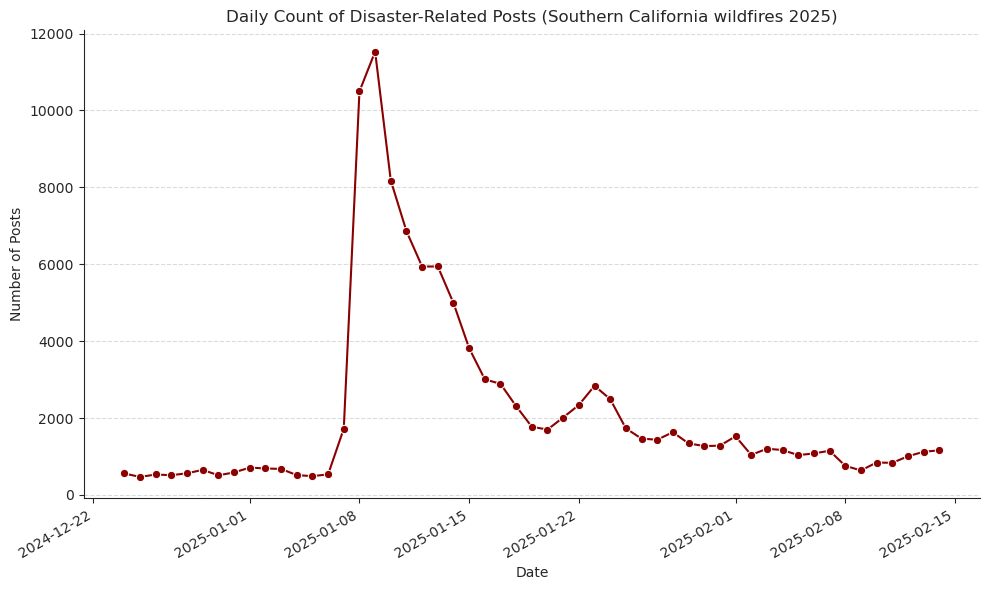

In [14]:
# 1. Ensure createdAt is datetime
socal_wildfires_gdf['createdAt'] = pd.to_datetime(socal_wildfires_gdf['createdAt'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

# 2. Filter for disaster-related posts
disaster_df = socal_wildfires_gdf[socal_wildfires_gdf['disaster_related'] == 1]

# 3. Group by day and count posts, filling missing days with zero
daily_counts = (
    disaster_df
    .set_index('createdAt')
    .resample('D')
    .size()
    .asfreq('D', fill_value=0)
).reset_index(name='count')

# 4. Plot the time series
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=daily_counts, x='createdAt', y='count', ax=ax, marker='o', color='darkred')
ax.set_title('Daily Count of Disaster-Related Posts (Southern California wildfires 2025)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Posts')
ax.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(ax=ax, top=True, right=True)
fig.autofmt_xdate()
fig.tight_layout()

# 5. Add dashed line on January 7
# sep12 = pd.to_datetime('2025-01-07')  # ← change year as needed
# ax.axvline(sep12, color='k', linestyle='--', linewidth=2, label='Jam 07')

How about a wordcloud?

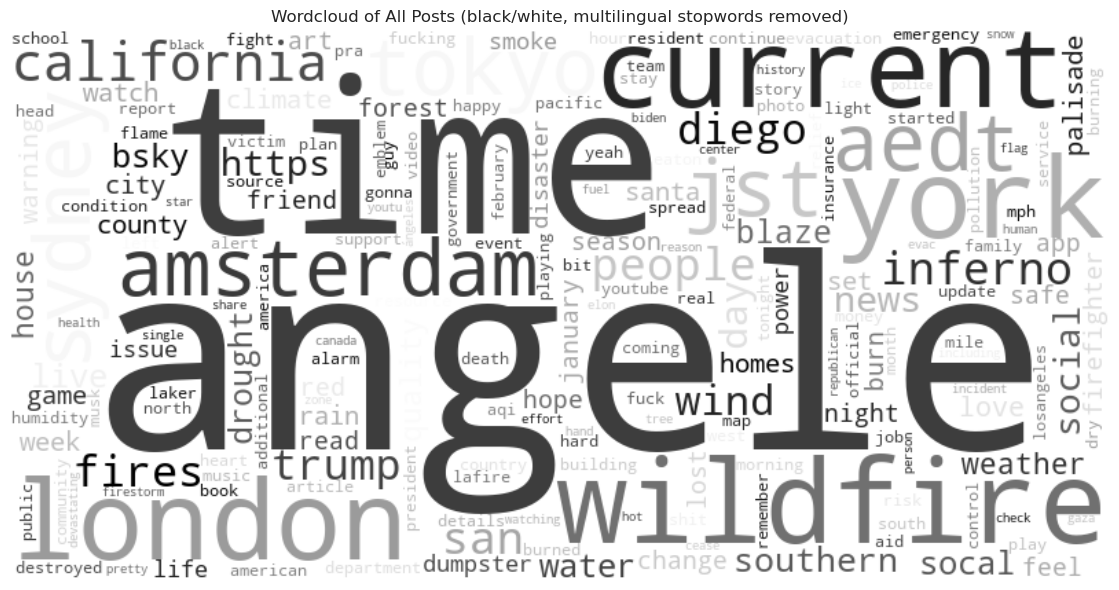

In [15]:
texts: list = socal_wildfires_gdf['text'].dropna().astype(str)

# concatenate all tweets into one large string, lowercase
all_text: list = " ".join(texts).lower()

# stop-words in ~200 languages
stopwords: list[str] = siso.stopwords(siso.langs())

# Generate the wordcloud
wc = WordCloud(
    width=800, 
    height=400,
    background_color='white',       # white canvas
    stopwords=stopwords,            # filter out all languages
    collocations=False,             # don’t show common bigrams like “new york”
    colormap='gray'
).generate(all_text)


plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud of All Posts (black/white, multilingual stopwords removed)")
plt.tight_layout()
plt.show()

What about the languages?

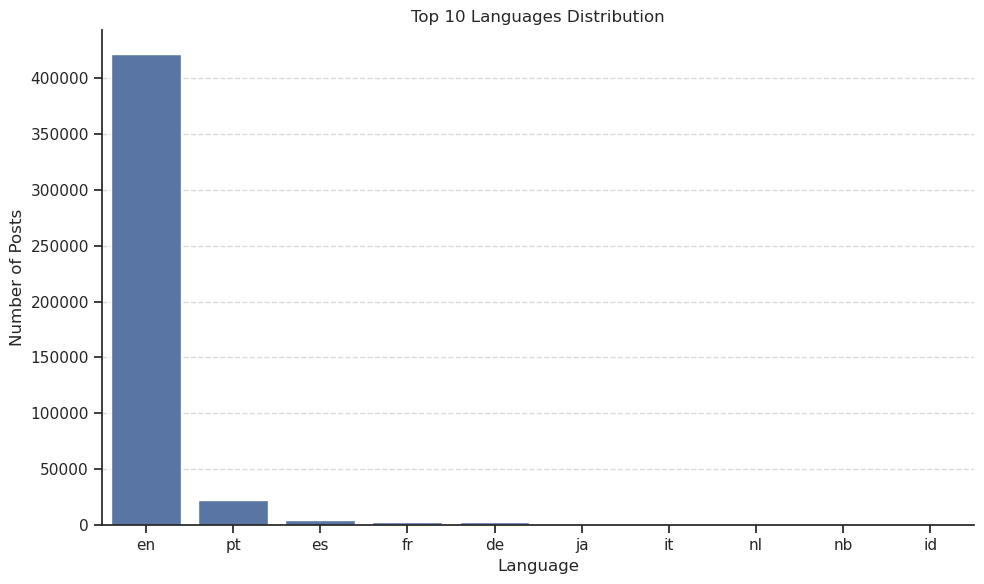

In [18]:
# 1. Compute top 10 language counts
lang_counts = (
    socal_wildfires_gdf['language']
    .value_counts()
    .nlargest(10)
    .reset_index()
)
lang_counts.columns = ['language', 'count']

# 2. Create the barplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=lang_counts, x='language', y='count', ax=ax)
ax.set_title('Top 10 Languages Distribution')
ax.set_xlabel('Language')
ax.set_ylabel('Number of Posts')
ax.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()

Next, we check the distribution of emotions.

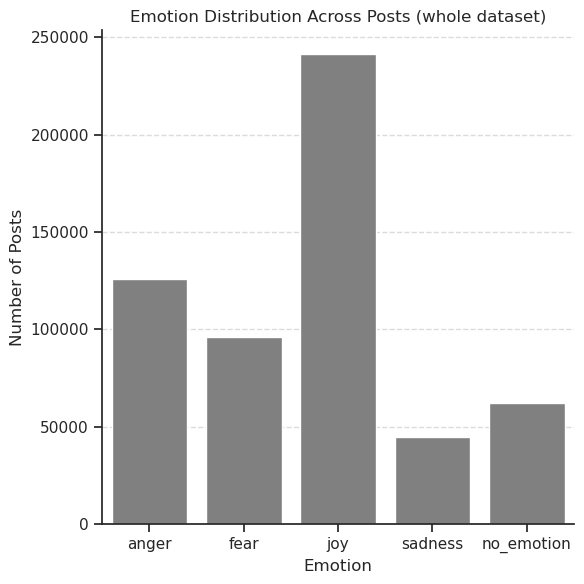

In [20]:
# 1. List your binary emotion columns
emotions = ['anger', 'fear', 'joy', 'sadness', 'no_emotion']

# 2. Sum up how many posts have each emotion
emotion_counts = (
    socal_wildfires_gdf[emotions]
    .sum()
    .reset_index()
)
emotion_counts.columns = ['emotion', 'count']

# 3. Plot
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=emotion_counts, x='emotion', y='count', ax=ax, color='gray')
ax.set_title('Emotion Distribution Across Posts (whole dataset)')
ax.set_xlabel('Emotion')
ax.set_ylabel('Number of Posts')
ax.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()

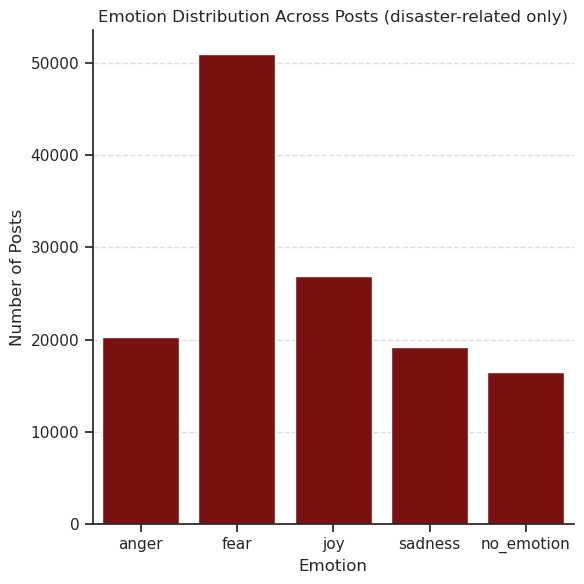

In [21]:
# 1. List your binary emotion columns
emotions = ['anger', 'fear', 'joy', 'sadness', 'no_emotion']

# 2. Sum up how many posts have each emotion
emotion_counts = (
    socal_wildfires_gdf[socal_wildfires_gdf['disaster_related']== 1][emotions]
    .sum()
    .reset_index()
)
emotion_counts.columns = ['emotion', 'count']

# 3. Plot
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=emotion_counts, x='emotion', y='count', ax=ax, color='darkred')
ax.set_title('Emotion Distribution Across Posts (disaster-related only)')
ax.set_xlabel('Emotion')
ax.set_ylabel('Number of Posts')
ax.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()

The mapping will be done in QGIS!